In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
#Load cleaned dataset
data = pd.read_csv('../../Results/Cleaned_JobDescs.csv', header = 0, names = ['Query', 'Description'])
#data = pd.read_csv('../../Results/Cleaned_JobsNonIT.csv', header = 0, names = ['Query', 'Description'])

In [3]:
#Split the dataset to Training and Test subsets (90/10)
train, test = train_test_split(data, test_size = 0.1, random_state = 17) #random_state = None

train_descs = train['Description']
train_labels = train['Query']
 
test_descs = test['Description']
test_labels = test['Query']

In [4]:
# Model Parameters
vocab_size = 1000

sequences_length = 1200

embedding_dimensionality = 64 #possibly low??
max_features = 2000 #equal to vocab_size

num_labels = len(train_labels.unique())
batch_size = 32
nb_epoch = 20

nof_filters = 200
kernel_size = 16

hidden_dims = 512

In [5]:
# Convert Texts to Numeric Vectors for Input
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_descs)

x_train = tokenizer.texts_to_sequences(train_descs)
x_test = tokenizer.texts_to_sequences(test_descs)

x_train = sequence.pad_sequences(x_train, maxlen = sequences_length, padding = 'post')
x_test = sequence.pad_sequences(x_test, maxlen = sequences_length, padding = 'post')

encoder = LabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [6]:
model = Sequential()
model.add(Embedding(max_features, embedding_dimensionality, input_length = 1200))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides = 1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', #'sgd', 'adam', 'RMSprop', 'Adagrad'
                   metrics = [metrics.categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1200, 64)          128000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1185, 200)         205000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                12825     
__________

In [7]:
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = nb_epoch,
                    verbose = True,
                    validation_split = 0.2)

Train on 7200 samples, validate on 1800 samples
Epoch 1/20
7200/7200 [==============================] - 183s 25ms/step - loss: 2.9007 - categorical_accuracy: 0.1451 - val_loss: 2.0295 - val_categorical_accuracy: 0.3517
Epoch 2/20
7200/7200 [==============================] - 230s 32ms/step - loss: 1.6704 - categorical_accuracy: 0.4907 - val_loss: 1.3615 - val_categorical_accuracy: 0.5828
Epoch 3/20
7200/7200 [==============================] - 233s 32ms/step - loss: 1.0874 - categorical_accuracy: 0.6639 - val_loss: 1.2265 - val_categorical_accuracy: 0.6228
Epoch 4/20
7200/7200 [==============================] - 240s 33ms/step - loss: 0.7495 - categorical_accuracy: 0.7617 - val_loss: 1.1510 - val_categorical_accuracy: 0.6472
Epoch 5/20
7200/7200 [==============================] - 231s 32ms/step - loss: 0.4823 - categorical_accuracy: 0.8456 - val_loss: 1.2650 - val_categorical_accuracy: 0.6350
Epoch 6/20
7200/7200 [==============================] - 232s 32ms/step - loss: 0.2969 - categoric

In [8]:
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = True)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])


1000/1000 [==============================] - 7s 7ms/step

Test categorical_crossentropy: 1.6141056458950043
Categorical accuracy: 0.66


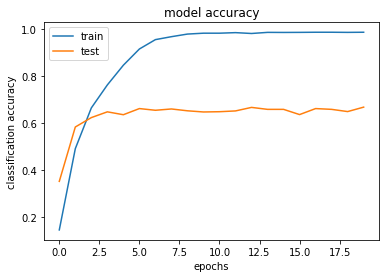

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('classification accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()